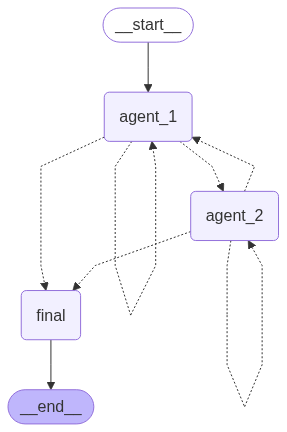

In [44]:
from typing import Literal
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from pydantic import BaseModel, Field
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import StateGraph, MessagesState, END, START
from IPython.display import display
from langgraph.types import Command
from IPython.display import Image 


class NextNode(BaseModel):
    next_node: Literal["final", "agent_1", "agent_2"] = Field(
        description="The next node to visit"
    )


class State(MessagesState):
    pass


llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash", temperature=1)
structured_output = llm.with_structured_output(NextNode)

system_prompt = """
return a random string among "agent_1", "agent_2" and "final".
Make sure everytime you return a different string.
"""


def agent_1(state: State) -> Command[Literal["final", "agent_1", "agent_2"]]:
    response = structured_output.invoke([SystemMessage(content=system_prompt)]+state["messages"])
    return Command(goto=response.next_node, update={"messages": [AIMessage(content=response.next_node), "continue"]})


def agent_2(state: State) -> Command[Literal["final", "agent_1", "agent_2"]]:
    response = structured_output.invoke([SystemMessage(content=system_prompt)]+state["messages"])
    return Command(goto=response.next_node, update={"messages": [AIMessage(content=response.next_node), "continue"]})


def final(state: State):
    print("final working.....")
    return Command(goto=END)


builder = StateGraph(State)

builder.add_node("agent_1", agent_1).add_edge(START, "agent_1")
builder.add_node("agent_2", agent_2)
builder.add_node("final", final)

graph = builder.compile()

# display the graph
display(Image(graph.get_graph().draw_mermaid_png()))


In [45]:
for event in graph.stream({"messages": "begin"}, stream_mode="updates"):
    print(event)

{'agent_1': {'messages': [AIMessage(content='agent_1', additional_kwargs={}, response_metadata={}, id='30641d1b-cad3-4e81-9b7f-9f685c1f4e90'), 'continue']}}
{'agent_1': {'messages': [AIMessage(content='agent_2', additional_kwargs={}, response_metadata={}, id='fc9dd4bf-241b-4165-a1dd-ab0b0b846e3e'), 'continue']}}
{'agent_2': {'messages': [AIMessage(content='final', additional_kwargs={}, response_metadata={}, id='9ac3dd66-14c1-4c65-819c-d8039f217804'), 'continue']}}
final working.....
{'final': None}
